# Energy Based Classification for MNIST

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np


In [18]:
pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import torchattacks
from torchattacks import PGD, FGSM, PGDL2

### Load Data

### Training

In [20]:
use_cuda = torch.cuda.is_available()  # not no_cuda and
batch_size = 100 #100
test_batch_size = 1000
lr = 0.02 #0.02
gamma = 0.8 #0.8
epochs = 10
seed = np.random.randint(0, 1000)
torch.manual_seed(seed)
np.random.seed(seed)

out = 1
n_classes = 10

In [21]:
class H1(nn.Module):
    # Hamiltonian neural network, as presented in [1,2].
    # H_1-DNN and H_2-DNN
    # General ODE: \dot{y} = J(y,t) K(t) \tanh( K^T(t) y(t) + b(t) )
    # Constraints:
    #   J(y,t) = J_1 = [ 0 I ; -I 0 ]  or  J(y,t) = J_2 = [ 0 1 .. 1 ; -1 0 .. 1 ; .. ; -1 -1 .. 0 ].
    # Discretization method: Forward Euler
    def __init__(self, n_layers, t_end, nf, random=True, select_j='J1',n_classes=5):
        super().__init__()

        self.n_layers = n_layers  # nt: number of layers
        self.h = t_end / self.n_layers  #interval
        self.act = nn.Tanh()    # activation function
        self.nf = nf            # number of features
        self.n_classes = n_classes # number of classes
        self.Y_ALL = []

        if random:
            K = torch.randn(self.nf, self.nf, self.n_layers-1)
            b = torch.randn(self.nf, 1, self.n_layers-1)
            final_K = torch.randn(self.nf, self.n_classes,1)
            final_b = torch.randn(self.n_classes, 1, 1)
        else:
            K = torch.ones(self.nf, self.nf, self.n_layers-1)
            b = torch.zeros(self.nf, 1, self.n_layers-1)
            final_K = torch.ones(self.nf, self.n_classes, 1)
            final_b = torch.zeros(self.n_classes, 1, 1)
        
        self.K = nn.Parameter(K, True)
        self.b = nn.Parameter(b, True)
        self.final_K = nn.Parameter(final_K, True)
        self.final_b = nn.Parameter(final_b, True)

        if select_j == 'J1':
            j_identity = torch.eye(self.nf//2)
            j_zeros = torch.zeros(self.nf//2, self.nf//2)
            self.J = torch.cat((torch.cat((j_zeros, j_identity), 0), torch.cat((- j_identity, j_zeros), 0)), 1)
        else:
            j_aux = np.hstack((np.zeros(1), np.ones(self.nf-1)))
            J = j_aux
            for j in range(self.nf-1):
                j_aux = np.hstack((-1 * np.ones(1), j_aux[:-1]))
                J = np.vstack((J, j_aux))
            self.J = torch.tensor(J, dtype=torch.float32)

    def getK(self):
        return self.K

    def getb(self):
        return self.b

    def getJ(self):
        return self.J

    def getY_ALL(self):
        return self.Y_ALL

    def forward(self, Y0, ini=0, end=None):

        dim = len(Y0.shape)
        Y = Y0.transpose(1, dim-1)

        if end is None:
            end = self.n_layers
          
        self.Y_ALL = []
        # print('Y',Y.shape)
        # print('K',self.K.shape)
        # print('b',self.b.shape)
        # print('J',self.J.shape)
        
        for j in range(ini, end-1):
            Y = Y + self.h * F.linear(self.act(F.linear(
                Y, self.K[:, :, j].transpose(0, 1), self.b[:, 0, j])), torch.matmul(self.J, self.K[:, :, j]))
            self.Y_ALL.append(Y)
            
        NNoutput = Y.transpose(1, dim-1)

        return NNoutput, self.K, self.b

In [22]:
def logcos(x):
    return x + torch.log(1+torch.exp(-2.0*x)) - torch.log(torch.tensor(2.0))
    # return torch.abs(x) + torch.log(1+torch.exp(-2.0*torch.abs(x))) - torch.log(torch.tensor(2.0))

In [23]:
def compute_H(y,K,b):
    dim = len(y.shape)
    y = y.transpose(1, dim-1)
    n_layers = K.shape[-1]
    H = torch.sum(logcos(F.linear(
                y.squeeze(2), K[:, :, n_layers-1].transpose(0, 1), b[:, 0, n_layers-1])),dim-1)
    return H

In [24]:
def compute_all_H(y,K,b):
  H_ALL = []
  
  n_layers = K.shape[-1]
  
  for layer in range(n_layers):
    dim = len(y[layer].shape)
    current_state = y[layer]

    # print('state:',current_state.squeeze(2).shape)
    # print("K:",K[:, :, layer].transpose(0, 1).shape)
    # print('b:',b[:, 0, layer].shape)

    H_ALL.append(torch.sum(torch.log(torch.cosh(F.linear(
                current_state.squeeze(2), K[:, :, layer].transpose(0, 1), b[:, 0, layer]))),dim-1))
  
  return H_ALL

In [25]:
class Net_Energy_All_Layers(nn.Module):
    def __init__(self, nf=8, n_layers=4, h=0.5, net_type='H1_J1'):
        super(Net_Energy_All_Layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=nf, kernel_size=3, stride=1, padding=1)
        self.hamiltonian = H1(n_layers=n_layers, t_end=h * n_layers, nf=nf, select_j='J1')
        self.fc_end0 = nn.Linear((n_layers-1)*28*28,10)
        # self.fc_end1 = nn.Linear(128,10)
        self.nf = nf
        self.H = []
        self.H_ALL = []
    
    def get_all_H(self):
        return self.H_ALL

    def getH(self):
        return self.H

    def forward(self, x):
        x = self.conv1(x)
        x,K,b = self.hamiltonian(x)
        self.H = compute_H(x,K,b)

        all_states = self.hamiltonian.getY_ALL()
        self.H_ALL = compute_all_H(all_states,K,b)
        H_ALL_tensor = torch.stack(self.H_ALL,dim=1)
        x = H_ALL_tensor.reshape(-1,(n_layers-1)*28*28)
        output = self.fc_end0(x)
        # output = self.fc_end1(x)
        # output = F.log_softmax(x, dim=1)
        return output

In [26]:
# Define the net model
n_layers = 4
net_type = 'H1_J1'

h = 0.4
wd = 4e-3
alpha = 8e-3
alpha_H = 0 #1e-5


device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 20, 'pin_memory': True} if use_cuda else {}
model = Net_Energy_All_Layers(nf=8, n_layers=n_layers, h=h, net_type=net_type).to(device)

print("\n------------------------------------------------------------------")
print("MNIST dataset - %s-DNN - %i layers" % (net_type, n_layers))
print("== sgd with Adam (lr=%.1e, weight_decay=%.1e, gamma=%.1f, max_epochs=%i, alpha=%.1e, minibatch=%i)" %
      (lr, wd, gamma, epochs, alpha, batch_size))

best_acc = 0
best_acc_train = 0


------------------------------------------------------------------
MNIST dataset - H1_J1-DNN - 4 layers
== sgd with Adam (lr=2.0e-02, weight_decay=4.0e-03, gamma=0.8, max_epochs=10, alpha=8.0e-03, minibatch=100)


In [27]:
# Load train data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
# Load test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [28]:
# Define optimization algorithm
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

# Scheduler for learning_rate parameter
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [29]:
def regularization(alpha, h, K, b, H_ALL, alpha_H):
    # Regularization function as introduced in [1]
    n_layers = K.shape[-1]
    loss = 0
    for j in range(n_layers - 1):
        loss = loss + alpha * h * (1 / 2 * torch.norm(K[:, :, j + 1] - K[:, :, j]) ** 2 +
                                   1 / 2 * torch.norm(b[:, :, j + 1] - b[:, :, j]) ** 2) + alpha_H * h *  1 / 2 * torch.norm(H_ALL[j+1] - H_ALL[j]) ** 2
    return loss

In [30]:
def train(model, device, train_loader, optimizer, epoch, alpha, out, alpha_H, gradient_info=False):
    model.train()

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss_local = F.cross_entropy(output, target)
        K = model.hamiltonian.getK()
        b = model.hamiltonian.getb()
        H_ALL = model.get_all_H()
        # for j in range(int(model.hamiltonian.n_layers) - 1):
        loss_local = loss_local + regularization(alpha, h, K, b, H_ALL, alpha_H)
        loss = loss_local
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0 and out>0:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()
            print('\tTrain Epoch: {:2d} [{:5d}/{} ({:2.0f}%)]\tLoss: {:.6f}\tAccuracy: {}/{}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), correct, len(data)))

In [31]:
def test(model, device, test_loader, out):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Test set:\tAverage loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct

In [32]:


for epoch in range(1, epochs + 1):
  
    train(model, device, train_loader, optimizer, epoch, alpha, out, alpha_H)
    test_acc = test(model, device, test_loader, out)
    # Results over training set after training
    train_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            train_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    if out > 0:
        print('Train set:\tAverage loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            train_loss, correct, len(train_loader.dataset),
            100. * correct / len(train_loader.dataset)))
    scheduler.step()
    if best_acc < test_acc:
        best_acc = test_acc
        best_acc_train = correct

print("\nNetwork trained!")
print('Test accuracy: {:.2f}%  - Train accuracy: {:.3f}% '.format(
      100. * best_acc / len(test_loader.dataset), 100. * best_acc_train / len(train_loader.dataset)))
print("------------------------------------------------------------------\n")



	Train Epoch:  1 [    0/60000 ( 0%)]	Loss: 29.005226	Accuracy: 11/100
	Train Epoch:  1 [10000/60000 (17%)]	Loss: 2.975197	Accuracy: 84/100
	Train Epoch:  1 [20000/60000 (33%)]	Loss: 2.190882	Accuracy: 86/100
	Train Epoch:  1 [30000/60000 (50%)]	Loss: 1.152916	Accuracy: 89/100
	Train Epoch:  1 [40000/60000 (67%)]	Loss: 0.913355	Accuracy: 92/100
	Train Epoch:  1 [50000/60000 (83%)]	Loss: 1.263441	Accuracy: 88/100
Test set:	Average loss: 0.4631, Accuracy:  9094/10000 (90.94%)
Train set:	Average loss: 0.4524, Accuracy: 54569/60000 (90.95%)
	Train Epoch:  2 [    0/60000 ( 0%)]	Loss: 0.948755	Accuracy: 92/100
	Train Epoch:  2 [10000/60000 (17%)]	Loss: 0.773973	Accuracy: 89/100
	Train Epoch:  2 [20000/60000 (33%)]	Loss: 0.565647	Accuracy: 92/100
	Train Epoch:  2 [30000/60000 (50%)]	Loss: 0.784079	Accuracy: 85/100
	Train Epoch:  2 [40000/60000 (67%)]	Loss: 0.508304	Accuracy: 94/100
	Train Epoch:  2 [50000/60000 (83%)]	Loss: 0.548696	Accuracy: 95/100
Test set:	Average loss: 0.2832, Accuracy:  9

In [33]:
torch.save(model,'Net_Energy_all_layers_9571.pkl')

In [ ]:
torch.save(model,'Net_Energy_all_layers_reg_9697.pkl') 


In [ ]:
torch.save(model,'Net_Energy_all_layers_9layers_9631.pkl')

In [ ]:
model

Net_Energy_All_Layers(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end0): Linear(in_features=6272, out_features=10, bias=True)
)

## Noise

In [ ]:
from skimage.util import random_noise 


In [ ]:
model = torch.load("Net_Energy_all_layers_reg_lr_0.004-9513.pkl")

In [ ]:
def test_gaussian(model, device, test_loader, out, var=0.05, count=0):
    model.eval()
    test_loss = 0
    correct = 0
    H = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data*0.3081 + 0.1307
            im_data = torch.tensor(random_noise(data, mode='gaussian', mean=0, var=var, clip=True)).float()
            im_data = (im_data-0.1307) / 0.3081
            output = model(im_data)
            if count != 2:
              H = model.getH()
            else:
              H = np.zeros(10)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Variance:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            var, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:9], H[0:9]

In [ ]:
def test_salt_pepper(model, device, test_loader, out, amount=0.05, count=0):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data*0.3081 + 0.1307
            im_data = torch.tensor(random_noise(data, mode='s&p', amount=amount)).float()
            im_data = (im_data-0.1307) / 0.3081
            output = model(im_data)
            if count != 2:
              H = model.getH()
            else:
              H = np.zeros(10)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Amount:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            amount, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:9], H[0:9]

In [ ]:
def test_gaussian_blur(model, device, out, kernel_size=3, sigma=(1,1), count=0):
    model.eval()
    test_loss = 0
    correct = 0
    H = []
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)),
                            transforms.GaussianBlur(kernel_size,sigma=sigma)
                        ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            im_data = data
            output = model(im_data)
            if count != 2:
              H = model.getH()
            else:
              H = np.zeros(10)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Kernel_size:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            kernel_size, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:9], H[0:9]

In [ ]:
vars = np.linspace(0,1.5,16)
acc_gaussian_all = torch.load("acc_gaussian_all.pt")
exp_gaussian_all = []
eng_gaussian_all = []
count = 0
print(model)
count += 1
acc_gaussian=[]
exp_gaussian=[]
eng_gaussian=[]
for var in vars:
  test_acc, examples, energy = test_gaussian(model, device, test_loader, out, var, count)
  acc_gaussian.append(test_acc)
  exp_gaussian.append(examples)
  eng_gaussian.append(energy)
acc_gaussian_all.append(acc_gaussian)
exp_gaussian_all.append(exp_gaussian)
eng_gaussian_all.append(eng_gaussian)

Net_Energy(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end0): Linear(in_features=2352, out_features=128, bias=True)
  (fc_end1): Linear(in_features=128, out_features=10, bias=True)
)
Variance:0.000 Average loss: 0.1774, Accuracy:  9513/10000 (95.13%)
Variance:0.100 Average loss: 1.8136, Accuracy:  6020/10000 (60.20%)
Variance:0.200 Average loss: 4.8350, Accuracy:  2846/10000 (28.46%)
Variance:0.300 Average loss: 7.6928, Accuracy:  1680/10000 (16.80%)
Variance:0.400 Average loss: 9.9367, Accuracy:  1348/10000 (13.48%)
Variance:0.500 Average loss: 11.5240, Accuracy:  1234/10000 (12.34%)
Variance:0.600 Average loss: 12.9165, Accuracy:  1191/10000 (11.91%)
Variance:0.700 Average loss: 13.9948, Accuracy:  1169/10000 (11.69%)
Variance:0.800 Average loss: 14.9173, Accuracy:  1152/10000 (11.52%)
Variance:0.900 Average loss: 15.6285, Accuracy:  1152/10000 (11.52%)
Variance:1.000 Average loss: 16.3548, Accuracy:  11

In [ ]:
amounts = np.linspace(0,0.9,10)
acc_salt_pepper_all = torch.load("acc_salt_pepper_all.pt")
exp_salt_pepper_all = []
eng_salt_pepper_all = []
count = 0
print(model)
count += 1
acc_salt_pepper=[]
exp_salt_pepper=[]
eng_salt_pepper=[]
for amount in amounts:
  test_acc, examples, energy = test_salt_pepper(model, device, test_loader, out, amount, count)
  acc_salt_pepper.append(test_acc)
  exp_salt_pepper.append(examples)
  eng_salt_pepper.append(energy)
acc_salt_pepper_all.append(acc_salt_pepper)
exp_salt_pepper_all.append(exp_salt_pepper)
eng_salt_pepper_all.append(eng_salt_pepper)

Net_Energy(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end0): Linear(in_features=2352, out_features=128, bias=True)
  (fc_end1): Linear(in_features=128, out_features=10, bias=True)
)
Amount:0.000 Average loss: 0.1774, Accuracy:  9513/10000 (95.13%)
Amount:0.100 Average loss: 1.4966, Accuracy:  6648/10000 (66.48%)
Amount:0.200 Average loss: 4.8496, Accuracy:  3298/10000 (32.98%)
Amount:0.300 Average loss: 9.1108, Accuracy:  1745/10000 (17.45%)
Amount:0.400 Average loss: 13.4027, Accuracy:  1263/10000 (12.63%)
Amount:0.500 Average loss: 17.1358, Accuracy:  1154/10000 (11.54%)
Amount:0.600 Average loss: 20.3376, Accuracy:  1136/10000 (11.36%)
Amount:0.700 Average loss: 22.8599, Accuracy:  1136/10000 (11.36%)
Amount:0.800 Average loss: 24.8149, Accuracy:  1136/10000 (11.36%)
Amount:0.900 Average loss: 26.1969, Accuracy:  1135/10000 (11.35%)


In [ ]:
kernel_sizes = np.linspace(3,27,7)
acc_gaussian_blur_all = torch.load("acc_gaussian_blur_all.pt")
exp_gaussian_blur_all = []
eng_gaussian_blur_all = []
count = 0

print(model)
count+=1
acc_gaussian_blur = []
exp_gaussian_blur = []
eng_gaussian_blur = []
for kernel_size in kernel_sizes:
  test_acc, examples, energy = test_gaussian_blur(model, device, out, kernel_size=kernel_size, sigma=5, count=count)
  acc_gaussian_blur.append(test_acc)
  exp_gaussian_blur.append(examples)
  eng_gaussian_blur.append(energy)
acc_gaussian_blur_all.append(acc_gaussian_blur)
exp_gaussian_blur_all.append(exp_gaussian_blur)
eng_gaussian_blur_all.append(eng_gaussian_blur)

Net_Energy(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end0): Linear(in_features=2352, out_features=128, bias=True)
  (fc_end1): Linear(in_features=128, out_features=10, bias=True)
)
Kernel_size:3.000 Average loss: 1.3196, Accuracy:  6557/10000 (65.57%)
Kernel_size:7.000 Average loss: 5.7778, Accuracy:  1816/10000 (18.16%)
Kernel_size:11.000 Average loss: 6.8215, Accuracy:  1139/10000 (11.39%)
Kernel_size:15.000 Average loss: 6.9473, Accuracy:  1135/10000 (11.35%)
Kernel_size:19.000 Average loss: 6.8304, Accuracy:  1135/10000 (11.35%)
Kernel_size:23.000 Average loss: 6.7328, Accuracy:  1135/10000 (11.35%)
Kernel_size:27.000 Average loss: 6.6852, Accuracy:  1135/10000 (11.35%)


## Plot

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def plot_energy(examples, energy, parameters, Title, y_label, is_regular):
  n_data = 0
  if is_regular:
    n_data = 0
  fig = plt.figure(figsize=(15,15))
  cnt = 0
  # plt.subplots_adjust(wspace = -0.01, hspace = -0.01)#调整子图间距
  for i in range(6): #6
      for j in range(2):
        cnt += 1
        ax = fig.add_subplot(6, 4, 2*cnt-1)
        # ax.axis('off')
        # plt.subplot(5,10,2*cnt-1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
          ax.set_ylabel(y_label+": {:.2f}".format(parameters[i]),fontsize=20)
        ex = examples[n_data][i][j]
        ax.imshow(ex.squeeze(0), cmap="gray")
        if i<1:
          ax.set_title('Input', fontsize=20)

        # plt.subplot(5,10,2*cnt)
        ax = fig.add_subplot(6,4,2*cnt)
        # plt.xticks([], [])
        # plt.yticks([], [])
        ax.axis('off')
        H = energy[n_data][i][j]
        ax.imshow(H.data.numpy().T, cmap="gray")
        if i<1:
          ax.set_title('Energy', fontsize=20)
  plt.tight_layout()
  # plt.subplots_adjust( 
  #           wspace=0.1, 
  #           hspace=-0.7)
  plt.suptitle(Title,fontsize = 30,y=1.05)
  plt.show()

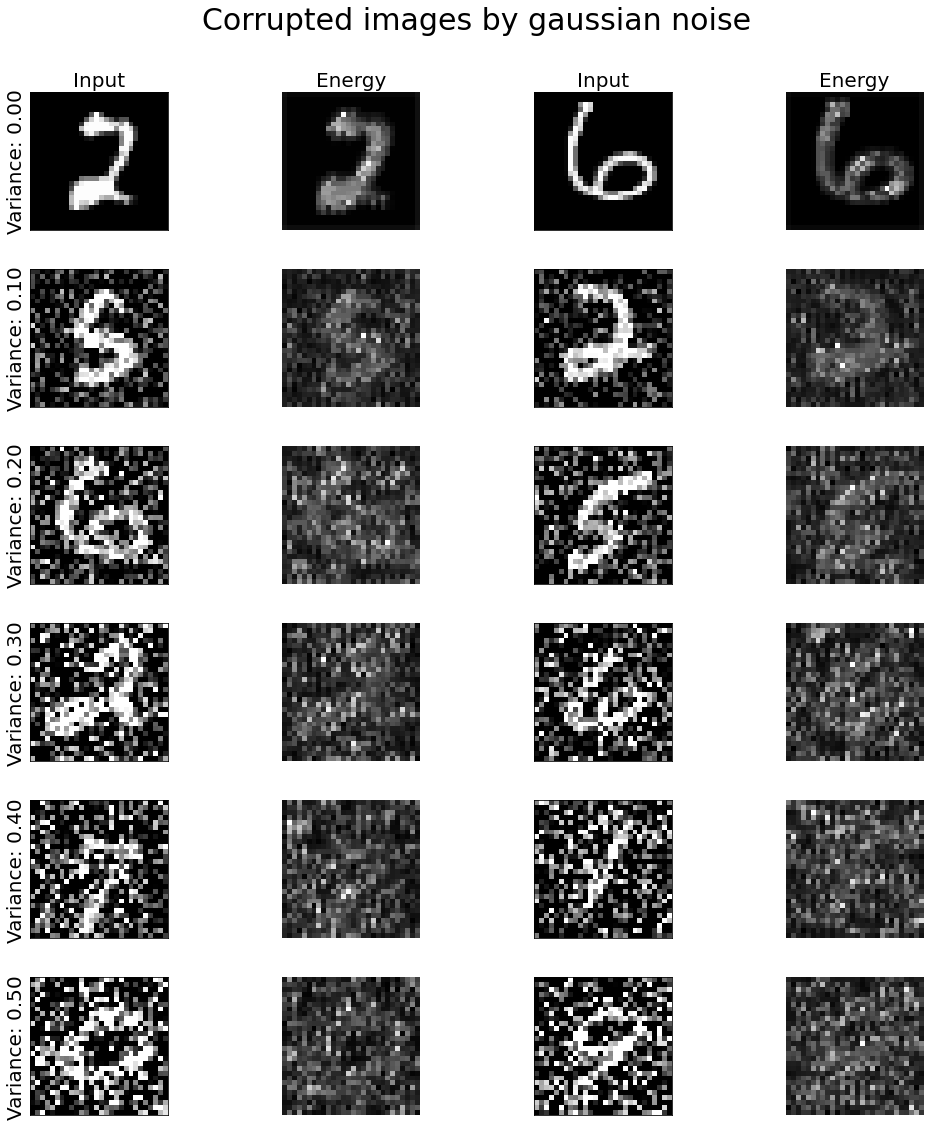

In [ ]:
plot_energy(exp_gaussian_all, eng_gaussian_all, vars, Title="Corrupted images by gaussian noise", y_label="Variance", is_regular=0)

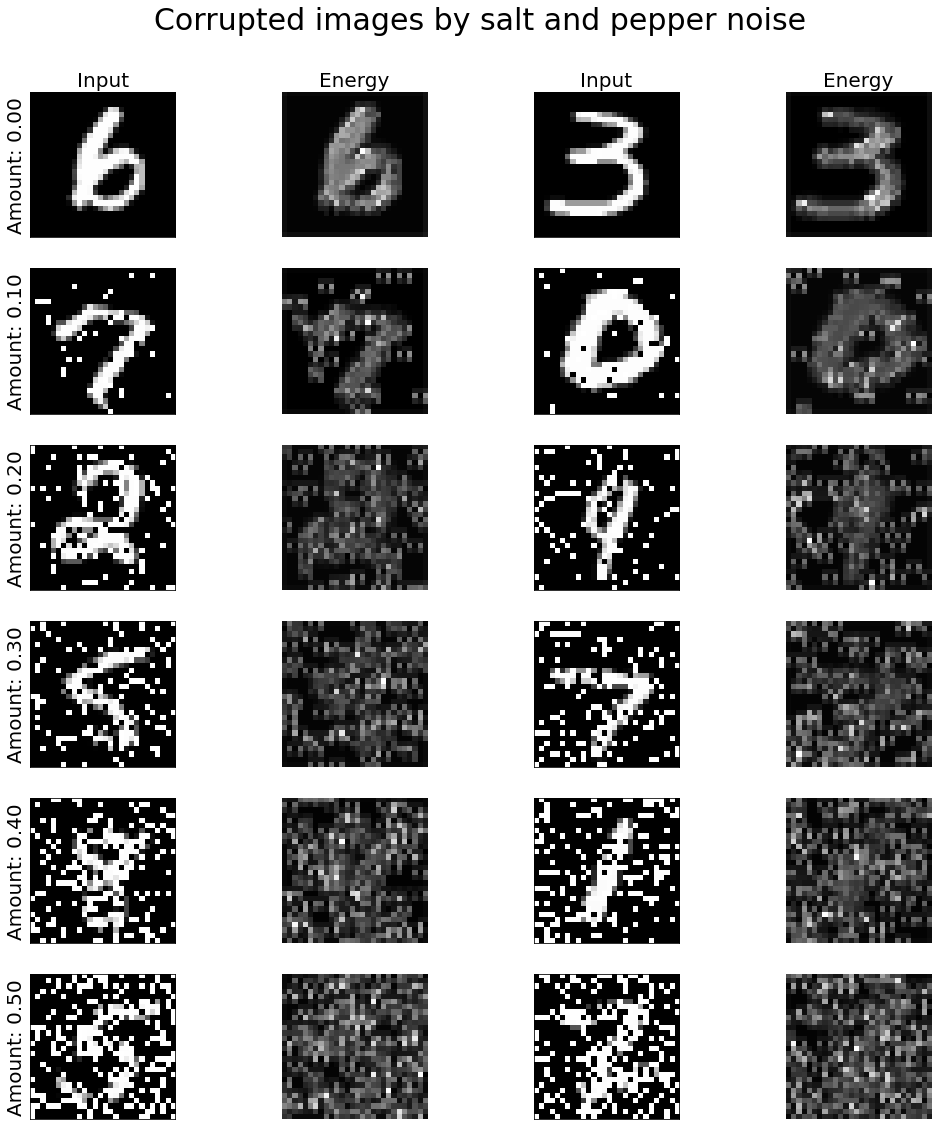

In [ ]:
plot_energy(exp_salt_pepper_all, eng_salt_pepper_all, amounts, Title="Corrupted images by salt and pepper noise", y_label="Amount", is_regular=0)

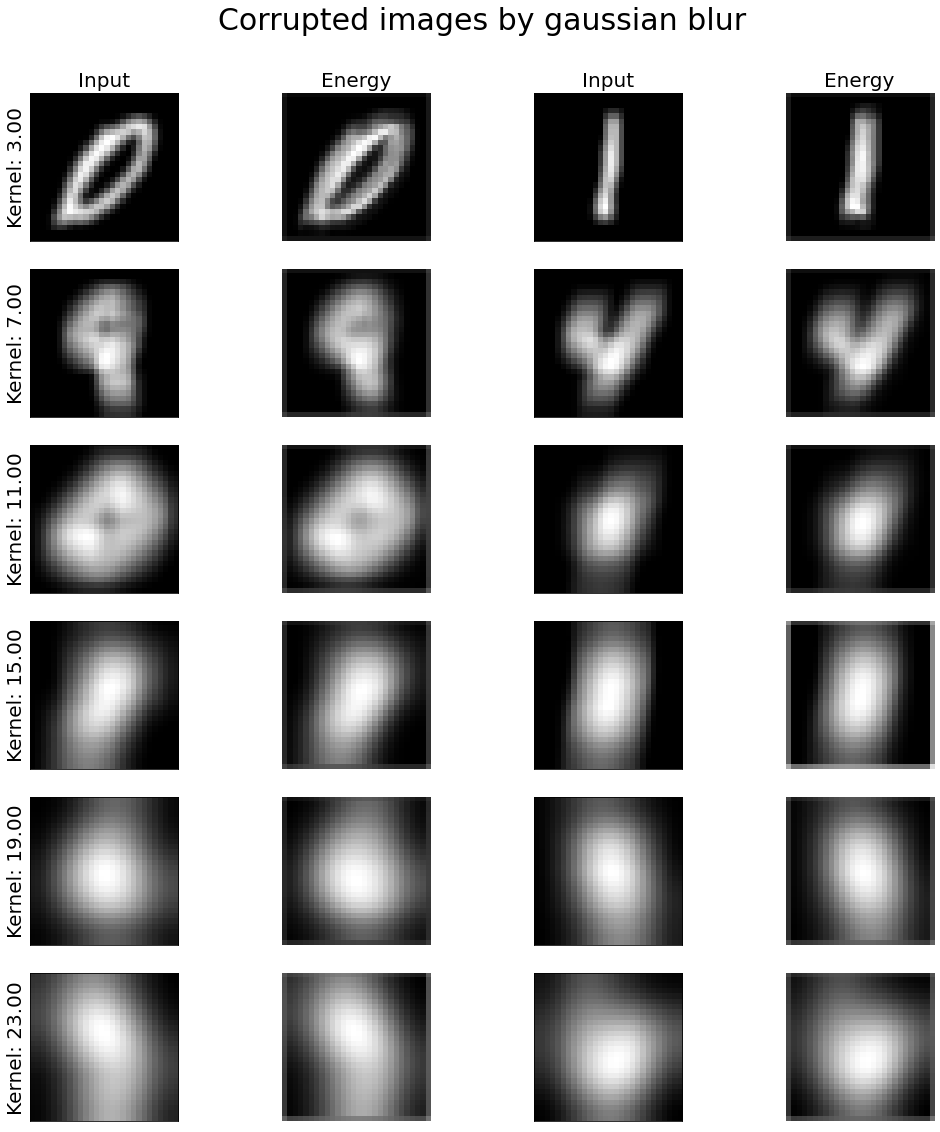

In [ ]:
plot_energy(exp_gaussian_blur_all, eng_gaussian_blur_all, kernel_sizes, Title="Corrupted images by gaussian blur", y_label="Kernel", is_regular=0)

In [ ]:
def plot_accuracy(parameters, accuracies, Title, x_label, x_step):
  plt.figure(figsize=(8,8))
  plt.plot(parameters, accuracies[0], "*-", label='Energy based')
  plt.plot(parameters, accuracies[1], "r*-", label='H-DNN')
  plt.plot(parameters, accuracies[2], "g*-", label='Energy based (regularized)')
  plt.plot(parameters, accuracies[3], "y*-", label='Energy based (regularized + all layers)')
  plt.yticks(np.arange(0, 1.1, step=0.1))
  plt.xticks(np.arange(0, max(parameters)+x_step, step=x_step))
  plt.title(Title)
  plt.xlabel(x_label)
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

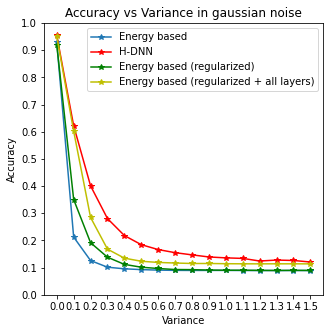

In [ ]:
plot_accuracy(vars, acc_gaussian_all, Title="Accuracy vs Variance in gaussian noise", x_label="Variance", x_step=0.1)

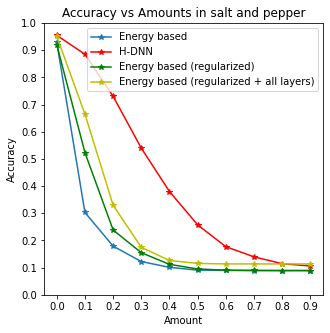

In [ ]:
plot_accuracy(amounts, acc_salt_pepper_all, Title="Accuracy vs Amounts in salt and pepper", x_label="Amount",x_step=0.1)

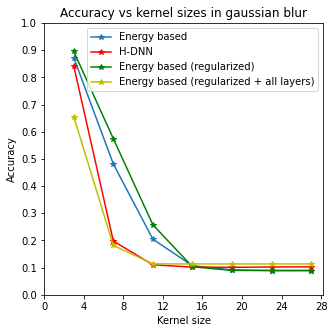

In [ ]:
plot_accuracy(kernel_sizes, acc_gaussian_blur_all, Title="Accuracy vs kernel sizes in gaussian blur", x_label="Kernel size",x_step=4)

## Attack

In [ ]:
def test_fgsm(model, device, test_loader, out, epsilon=0.05, count=0):
    model.eval()
    correct = 0
    test_loss = 0
    atk = FGSM(model, eps=epsilon)
    for data, target in test_loader:
        data = data*0.3081 + 0.1307
        im_data = atk(data, target)
        im_data = (im_data-0.1307) / 0.3081
        if count != 2:
            H = model.getH()
        else:
            H = np.zeros(10)
        output = model(im_data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Epsilon:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            epsilon, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:9], H[0:9]

In [ ]:
def test_pgd(model, device, test_loader, out, epsilon=0.05, count=0):
    model.eval()
    correct = 0
    test_loss = 0
    atk = PGD(model, eps=epsilon, alpha=0.1, steps=7)
    for data, target in test_loader:
        data = data*0.3081 + 0.1307
        im_data = atk(data, target)
        im_data = (im_data-0.1307) / 0.3081
        if count != 2:
            H = model.getH()
        else:
            H = np.zeros(10)
        output = model(im_data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Epsilon:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            epsilon, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:9], H[0:9]

In [ ]:
acc_fgsm_all = torch.load("acc_fgsm_all.pt")
exp_fgsm_all = []
eng_fgsm_all = []
epsilons_fgsm = np.linspace(0,0.25,6)
count = 0
print(model)

acc_fgsm = []
exp_fgsm = []
eng_fgsm = []
for epsilon in epsilons_fgsm:
    test_acc, examples, energy = test_fgsm(model, device, test_loader, out, epsilon, count)
    acc_fgsm.append(test_acc)
    exp_fgsm.append(examples)
    eng_fgsm.append(energy)

acc_fgsm_all.append(acc_fgsm)
exp_fgsm_all.append(exp_fgsm)
eng_fgsm_all.append(eng_fgsm)

Net_Energy(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end0): Linear(in_features=2352, out_features=128, bias=True)
  (fc_end1): Linear(in_features=128, out_features=10, bias=True)
)
Epsilon:0.000 Average loss: 0.1774, Accuracy:  9513/10000 (95.13%)
Epsilon:0.050 Average loss: 0.7328, Accuracy:  8126/10000 (81.26%)
Epsilon:0.100 Average loss: 2.4691, Accuracy:  5630/10000 (56.30%)
Epsilon:0.150 Average loss: 5.4161, Accuracy:  3305/10000 (33.05%)
Epsilon:0.200 Average loss: 8.7709, Accuracy:  1830/10000 (18.30%)
Epsilon:0.250 Average loss: 11.9992, Accuracy:  1084/10000 (10.84%)


In [ ]:
test_acc, examples, energy = test_fgsm(model, device, test_loader, out, epsilon=0.5, count=0)

Epsilon:0.500 Average loss: 21.5258, Accuracy:     2/10000 (0.02%)


In [ ]:
acc_pgd_all = torch.load("acc_pgd_all.pt")
exp_pgd_all = []
eng_pgd_all = []
epsilons_pgd = np.linspace(0,0.25,6)
count = 0
print(model)

acc_pgd=[]
exp_pgd=[]
eng_pgd=[]
for epsilon in epsilons_pgd:
    test_acc, examples, energy = test_pgd(model, device, test_loader, out, epsilon, count)
    acc_pgd.append(test_acc)
    exp_pgd.append(examples)
    eng_pgd.append(energy)

acc_pgd_all.append(acc_pgd)
exp_pgd_all.append(exp_pgd)
eng_pgd_all.append(eng_pgd)

Net_Energy(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end0): Linear(in_features=2352, out_features=128, bias=True)
  (fc_end1): Linear(in_features=128, out_features=10, bias=True)
)
Epsilon:0.000 Average loss: 0.1774, Accuracy:  9513/10000 (95.13%)
Epsilon:0.050 Average loss: 0.7298, Accuracy:  8129/10000 (81.29%)
Epsilon:0.100 Average loss: 2.4719, Accuracy:  5605/10000 (56.05%)
Epsilon:0.150 Average loss: 5.9313, Accuracy:  2939/10000 (29.39%)
Epsilon:0.200 Average loss: 10.6853, Accuracy:  1026/10000 (10.26%)
Epsilon:0.250 Average loss: 16.1962, Accuracy:    11/10000 (0.11%)


## Plot 

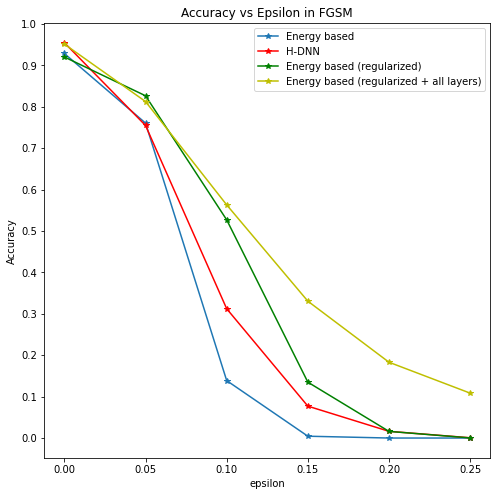

In [ ]:
plot_accuracy(epsilons_fgsm, acc_fgsm_all, Title="Accuracy vs Epsilon in FGSM", x_label="epsilon",x_step=0.05)

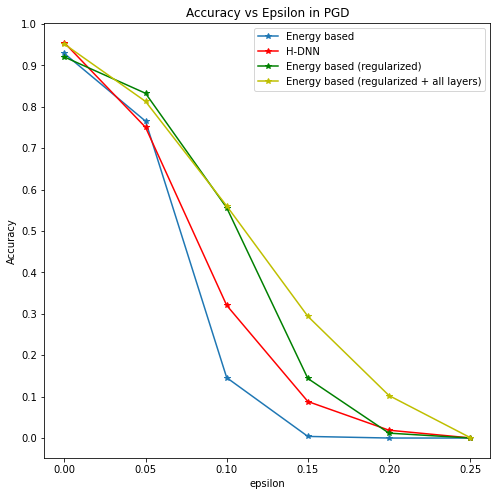

In [ ]:
plot_accuracy(epsilons_pgd, acc_pgd_all, Title="Accuracy vs Epsilon in PGD", x_label="epsilon",x_step=0.05)

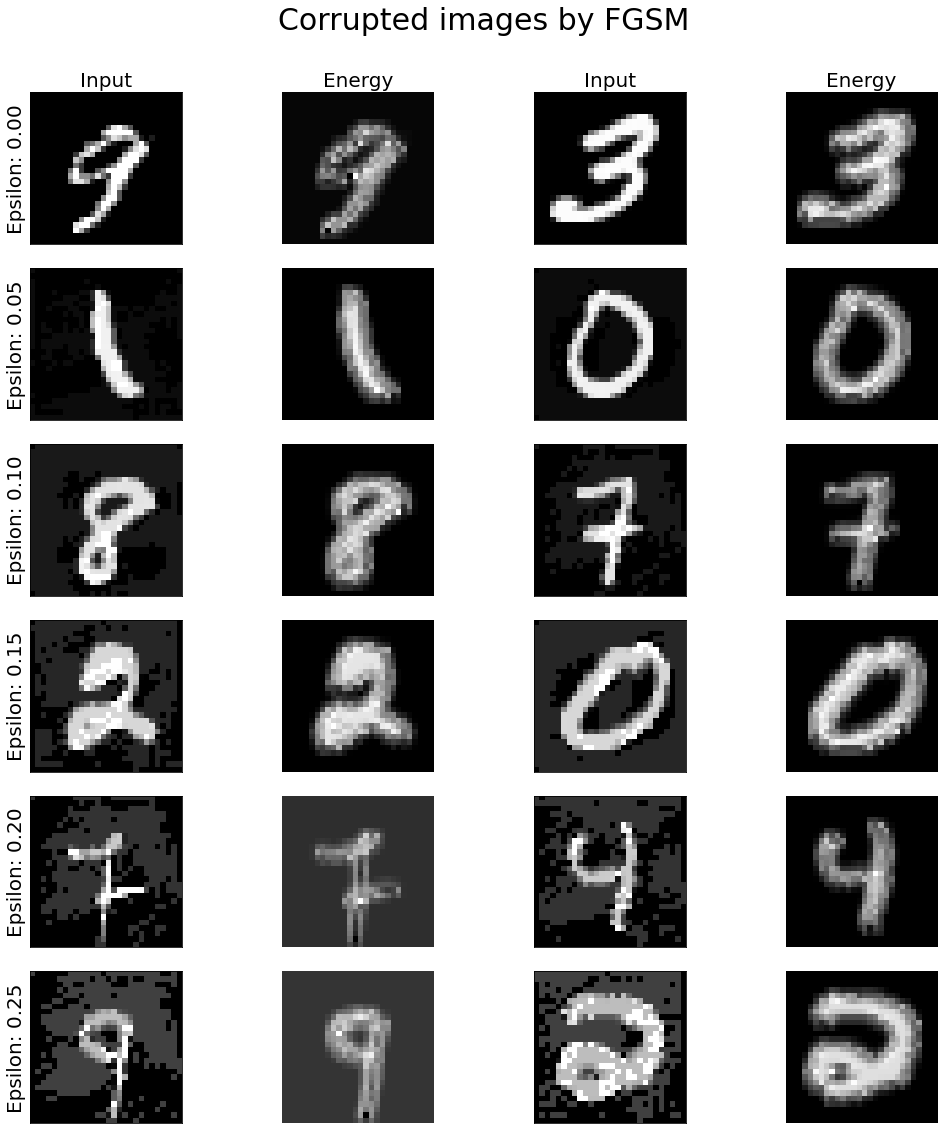

In [ ]:
plot_energy(exp_fgsm_all, eng_fgsm_all, epsilons_fgsm, Title="Corrupted images by FGSM", y_label="Epsilon", is_regular=0)

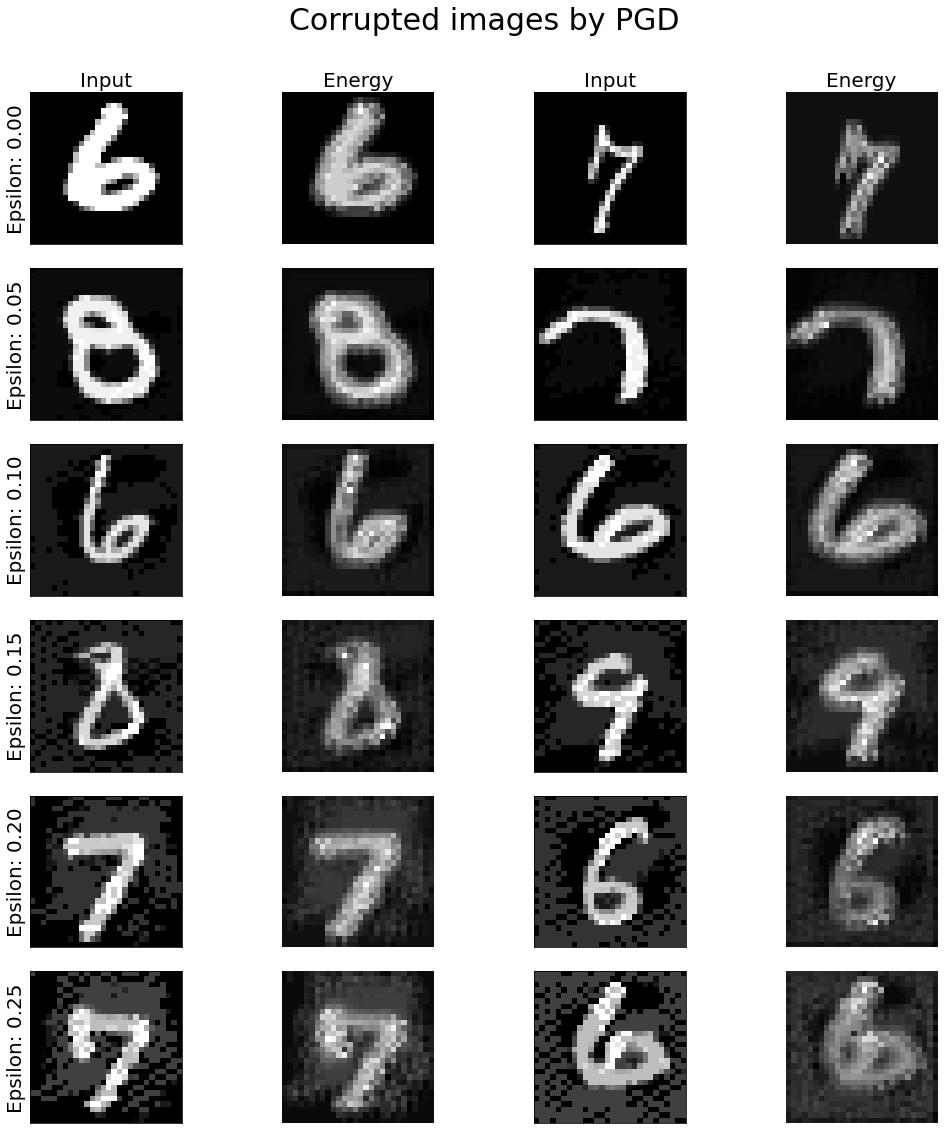

In [ ]:
plot_energy(exp_pgd_all, eng_pgd_all, epsilons_pgd, Title="Corrupted images by PGD", y_label="Epsilon", is_regular=0)

## save

In [ ]:
torch.save(acc_gaussian_all,"acc_gaussian_all.pt")
torch.save(acc_salt_pepper_all,"acc_salt_pepper_all.pt")
torch.save(acc_gaussian_blur_all,"acc_gaussian_blur_all.pt")
torch.save(acc_fgsm_all,"acc_fgsm_all.pt")
torch.save(acc_pgd_all,"acc_pgd_all.pt")


## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []
H_pred = []
inputs_all = []

# iterate over test data
for inputs, labels in test_loader:
        output,H = model(inputs) # Feed Network
        H_pred.extend(H)

        inputs_all.extend(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0', '1', '2', '3', '4',
        '5', '6', '7', '8', '9')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

In [ ]:
cf_matrix_per = np.zeros((10,10))
cf_matrix_char = np.chararray((10, 10))
for i in range(10):
  cf_matrix_per[i] = cf_matrix[i] / np.sum(cf_matrix[i])

for i in range(10):
  for j in range(10):
    cf_matrix_char[i][j] = "{:.2%}".format(cf_matrix_per[i][j])

In [ ]:
cf_matrix_per[i] = (cf_matrix[i] / np.sum(cf_matrix[i]))

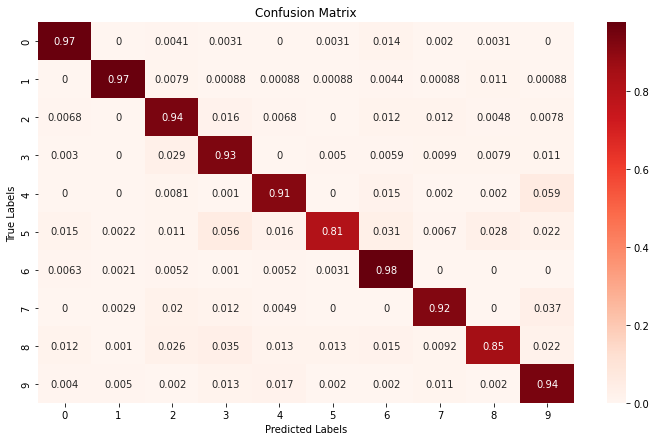

In [ ]:
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix_per, annot=True,cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig('output.png')

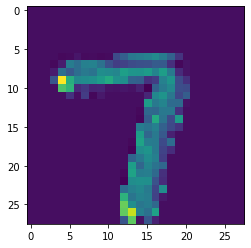

In [ ]:
plt.imshow(H_pred[1].data.numpy().T)

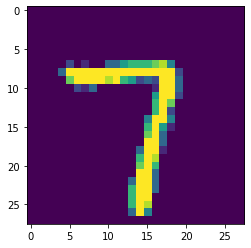

In [ ]:
plt.imshow(inputs_all[1].squeeze(0).data.numpy())

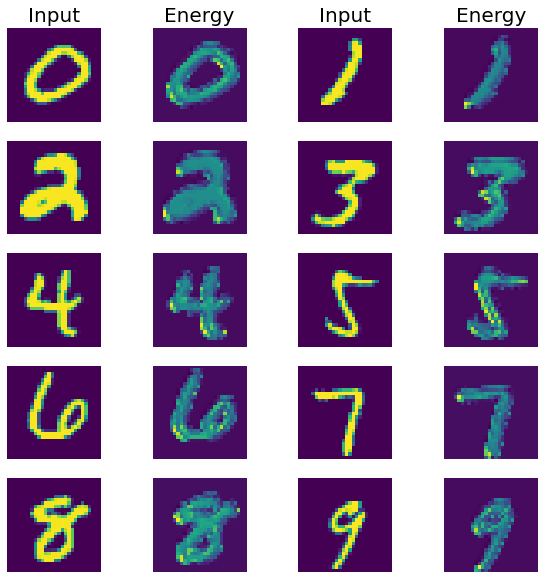

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
  for j in range(200):
    if y_true[j] == i:
      H = H_pred[j]
      inp = inputs_all[j]
      break
  ax = fig.add_subplot(5, 4, 2*i+1)
  ax.imshow(inp.squeeze(0).data.numpy())
  ax.axis('off')
  if i<=1:
    ax.set_title('Input', fontsize=20)
  ax = fig.add_subplot(5, 4, 2*i+2)
  ax.axis('off')
  if i<=1:
    ax.set_title('Energy', fontsize=20)
  ax.imshow(H.data.numpy().T)
  

In [ ]:
H = model.getH()

In [ ]:
H.shape

torch.Size([100, 28, 28])

In [ ]:
H_ALL[0].shape

torch.Size([100, 28, 28])

In [ ]:
s = '07:05:45PM'
str(int(s[0:2])+12)

'19'

In [ ]:
s[8:]

'PM'

In [ ]:
a = model(data)

Y torch.Size([100, 28, 28, 8])
K torch.Size([8, 8, 3])
b torch.Size([8, 1, 3])
J torch.Size([8, 8])


In [ ]:
a = torch.tensor(np.ones())

In [ ]:
H = model